In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go
from imblearn.over_sampling import SMOTE
from plotly.subplots import make_subplots

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score

import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=FutureWarning)

In [50]:
def explore(df):
    with pd.option_context("display.max_colwidth", 20):
        info = pd.DataFrame()
        info['data type'] = df.dtypes
        info['percent missing'] = df.isnull().sum()*100/len(df)
        info['No. unique'] = df.apply(lambda x: len(x.unique()))
        info['unique values'] = df.apply(lambda x: x.unique())
        return info.sort_values('data type')

In [51]:
df = pd.read_csv('FastagFraudDetection.csv')

# Data Exploration

In [52]:
explore(df)

,data type,percent missing,No. unique,unique values
Transaction_ID,int64,0.00,5000,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
Transaction_Amount,int64,0.00,20,"[350, 120, 0, 140, 160, 180, 290, 110, 100, 13..."
Amount_paid,int64,0.00,23,"[120, 100, 0, 160, 90, 180, 350, 140, 110, 60,..."
Vehicle_Speed,int64,0.00,85,"[65, 78, 53, 92, 60, 105, 70, 88, 45, 72, 58, ..."
Timestamp,object,0.00,4423,"[1/6/2023 11:20, 1/7/2023 14:55, 1/8/2023 18:2..."
Vehicle_Type,object,0.00,7,"[Bus , Car, Motorcycle, Truck, Van, Sedan, SUV]"
FastagID,object,10.98,4452,"[FTG-001-ABC-121, FTG-002-XYZ-451, nan, FTG-04..."
TollBoothID,object,0.00,6,"[A-101, B-102, D-104, C-103, D-105, D-106]"
Lane_Type,object,0.00,2,"[Express, Regular]"
Vehicle_Dimensions,object,0.00,3,"[Large, Small, Medium]"


In [53]:
df.shape

(5000, 13)

In [54]:
df.describe()

,Transaction_ID,Transaction_Amount,Amount_paid,Vehicle_Speed
count,5000.000000,5000.00000,5000.000000,5000.000000
mean,2500.500000,161.06200,141.261000,67.851200
std,1443.520003,112.44995,106.480996,16.597547
min,1.000000,0.00000,0.000000,10.000000
25%,1250.750000,100.00000,90.000000,54.000000
50%,2500.500000,130.00000,120.000000,67.000000
75%,3750.250000,290.00000,160.000000,82.000000
max,5000.000000,350.00000,350.000000,118.000000


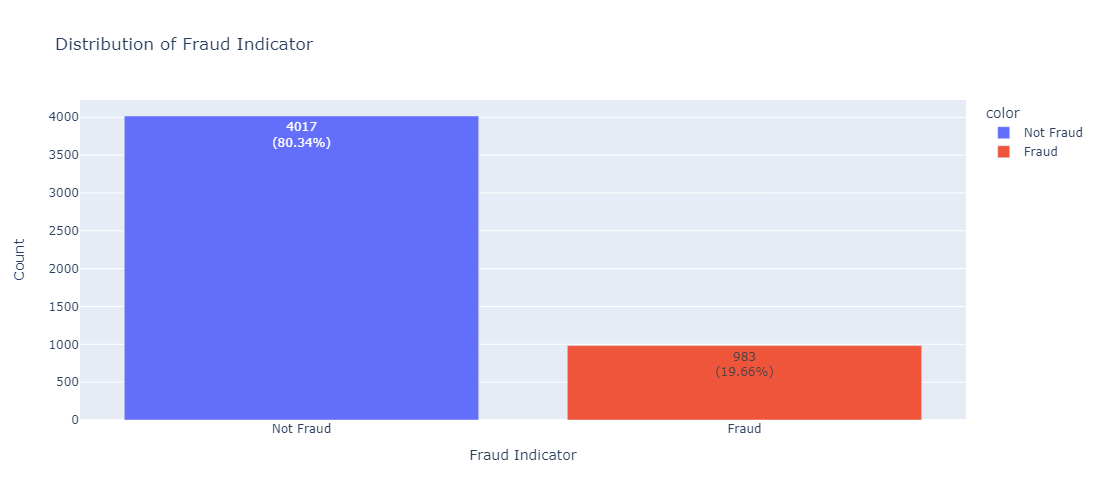

In [55]:
value_counts = df['Fraud_indicator'].value_counts()
percentages = (value_counts / len(df)) * 100

fig = px.bar(x=value_counts.index, y=value_counts.values, text=[f'{count}<br>({percent:.2f}%)' for count, percent in zip(value_counts.values, percentages.values)],
             labels={'x': 'Fraud Indicator', 'y': 'Count'}, title="Distribution of Fraud Indicator",
             color=value_counts.index)

fig.update_traces(textposition='inside')
fig.update_layout(xaxis=dict(type='category'),width=400,  
                  height=500)

fig.show()

# Feature Engieering

### Take first two letters from `Vehicle_Plate_Number` to create `State_code' columns

In [56]:
df['Vehicle_Plate_Number'].unique()

array(['KA11AB1234', 'KA66CD5678', 'KA88EF9012', ..., 'KA33WX6789',
       'KA35YZ0123', 'KA37AB3456'], dtype=object)

In [57]:
df['State_code'] = df['Vehicle_Plate_Number'].apply(lambda x: x[:2])

# Drop the original Vehicle_Type column
df.drop('Vehicle_Plate_Number', axis=1, inplace=True)

In [58]:
df['State_code'].unique()

array(['KA', 'MH', 'AP', 'GA', 'KL', 'GJ', 'TN', 'DL', 'TS', 'UP', 'RJ',
       'WB', 'MP', 'HR', 'BR'], dtype=object)

### Extract Hour and Month from `Timestamp`

In [59]:
df['Timestamp'].unique()

array(['1/6/2023 11:20', '1/7/2023 14:55', '1/8/2023 18:25', ...,
       '2/5/2023 5:08', '2/20/2023 20:34', '3/10/2023 0:59'], dtype=object)

In [60]:
# Convert Timestamp column to datetime format
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df['Hour'] = df['Timestamp'].dt.hour
df['Month'] = df['Timestamp'].dt.month

In [61]:
df['Hour'].unique()

array([11, 14, 18,  2,  6, 10, 15, 20,  1,  7, 12, 17, 22,  4,  8, 13, 16,
       21,  3, 23,  5,  9, 19,  0])

In [62]:
df['Month'].unique()

array([ 1,  2,  3,  4,  5,  6,  8,  9, 10,  7, 11, 12])

#### Prior to applying feature engineering techniques and converting columns into numerical formats, we make a duplicate of our dataset for exploratory data analysis purposes.

In [63]:
eda_df = df.copy()

In [64]:
explore(eda_df)

,data type,percent missing,No. unique,unique values
Transaction_ID,int64,0.00,5000,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
Timestamp,datetime64[ns],0.00,4423,"[2023-01-06 11:20:00, 2023-01-07 14:55:00, 202..."
Hour,int32,0.00,24,"[11, 14, 18, 2, 6, 10, 15, 20, 1, 7, 12, 17, 2..."
Month,int32,0.00,12,"[1, 2, 3, 4, 5, 6, 8, 9, 10, 7, 11, 12]"
Transaction_Amount,int64,0.00,20,"[350, 120, 0, 140, 160, 180, 290, 110, 100, 13..."
Amount_paid,int64,0.00,23,"[120, 100, 0, 160, 90, 180, 350, 140, 110, 60,..."
Vehicle_Speed,int64,0.00,85,"[65, 78, 53, 92, 60, 105, 70, 88, 45, 72, 58, ..."
Vehicle_Type,object,0.00,7,"[Bus , Car, Motorcycle, Truck, Van, Sedan, SUV]"
FastagID,object,10.98,4452,"[FTG-001-ABC-121, FTG-002-XYZ-451, nan, FTG-04..."
TollBoothID,object,0.00,6,"[A-101, B-102, D-104, C-103, D-105, D-106]"


# Exploratory Data Analysis

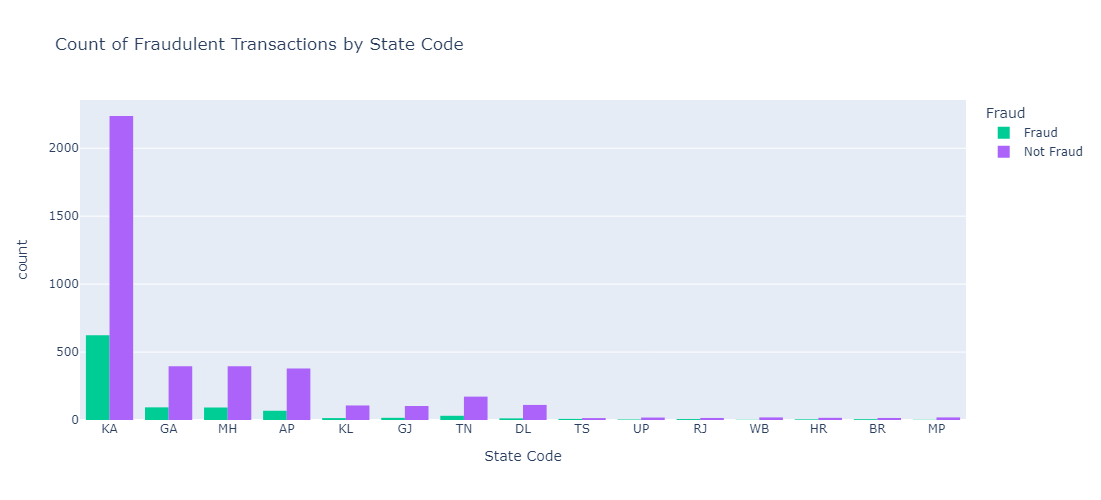

In [65]:
fig = px.histogram(eda_df, x='State_code', color='Fraud_indicator', barmode='group',
                   title='Count of Fraudulent Transactions by State Code',
                   labels={'State_code': 'State Code', 'Fraud_indicator': 'Fraud', 'count': 'Count of Transactions'},
                   color_discrete_map={'0': 'blue', '1': 'red'})
fig.update_layout(showlegend=True, 
                  width=1100,  
                  height=500)
fig.show()

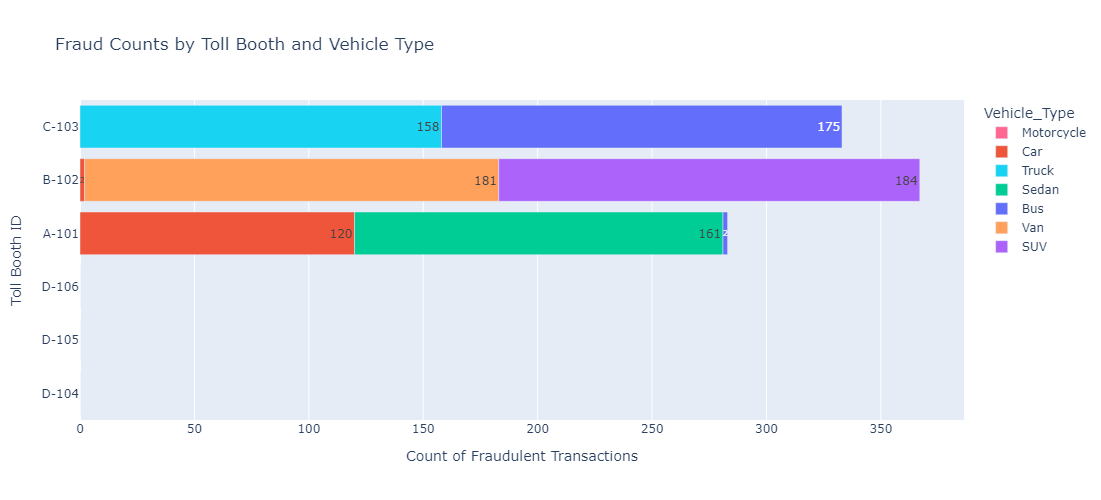

In [66]:
derived = eda_df.groupby(['TollBoothID', 'Vehicle_Type', 'Fraud_indicator']).size().reset_index(name='Count')
derived_pivot = derived.pivot_table(index=['TollBoothID', 'Vehicle_Type'], columns='Fraud_indicator', values='Count', fill_value=0).reset_index()

custom_palette = sns.color_palette("Set1", n_colors=len(derived_pivot['Vehicle_Type'].unique()))

fig = px.bar(derived_pivot, x='Fraud', y='TollBoothID', color='Vehicle_Type',
             title='Fraud Counts by Toll Booth and Vehicle Type',
             labels={'Fraud': 'Count of Fraudulent Transactions', 'TollBoothID': 'Toll Booth ID'},
             orientation='h')

fig.update_layout(width=1100,  
                  height=500)

fig.update_traces(texttemplate='%{x}', textposition='inside')

fig.data = sorted(fig.data, key=lambda x: sum(x['x']))

fig.show()

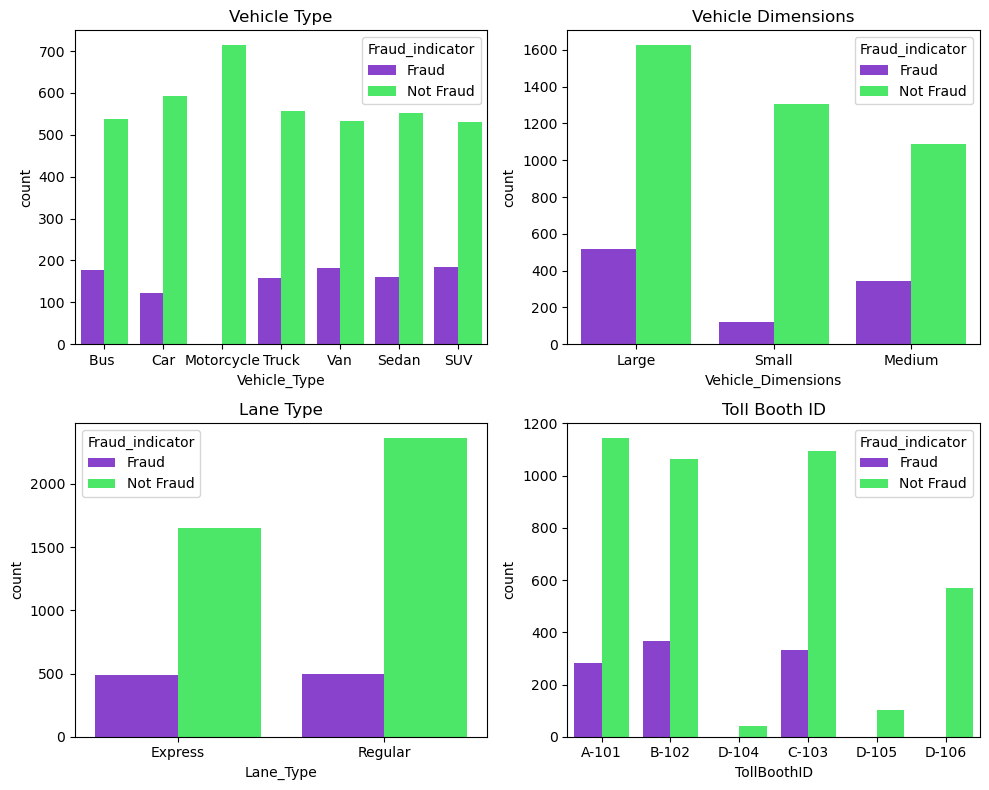

In [67]:
custom_colors = ["#8A2BE2", "#33FF57"]  # Violet and green colors

fig, axes = plt.subplots(2, 2, figsize=(10, 8))

sns.countplot(x='Vehicle_Type', data=eda_df, hue='Fraud_indicator', ax=axes[0, 0], palette=custom_colors)
axes[0, 0].set_title('Vehicle Type')

sns.countplot(x='Vehicle_Dimensions', data=eda_df, hue='Fraud_indicator', ax=axes[0, 1], palette=custom_colors)
axes[0, 1].set_title('Vehicle Dimensions')

sns.countplot(x='Lane_Type', data=eda_df, hue='Fraud_indicator', ax=axes[1, 0], palette=custom_colors)
axes[1, 0].set_title('Lane Type')

sns.countplot(x='TollBoothID', data=eda_df, hue='Fraud_indicator', ax=axes[1, 1], palette=custom_colors)
axes[1, 1].set_title('Toll Booth ID')

plt.tight_layout()

plt.show()

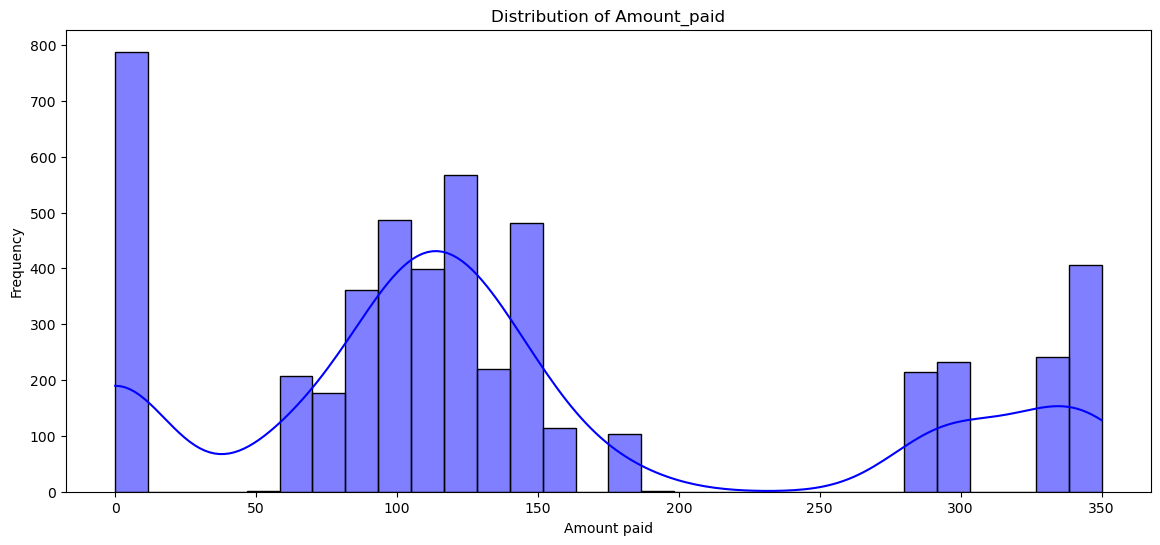

In [68]:
# Visualize the distribution of Amount using a histogram
plt.figure(figsize=(14, 6))
sns.histplot(eda_df['Amount_paid'], bins=30, kde=True, color='blue')
plt.title('Distribution of Amount_paid')
plt.xlabel('Amount paid')
plt.ylabel('Frequency')
plt.show()

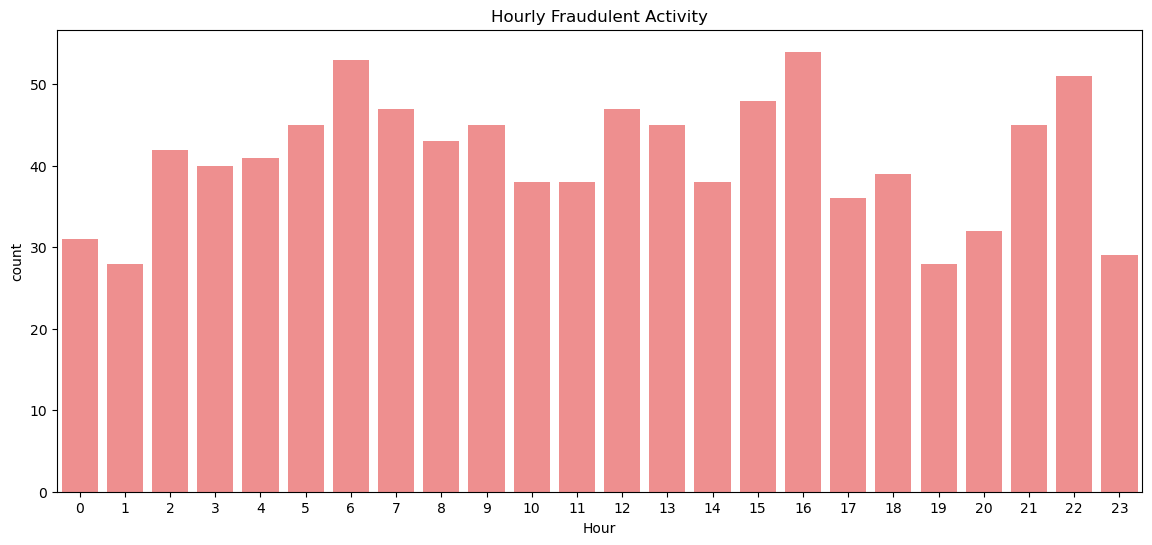

In [69]:
plt.figure(figsize=(14, 6))
sns.countplot(data=df[df['Fraud_indicator'] == 'Fraud'], x='Hour', palette=['red'], alpha=0.5)
plt.title('Hourly Fraudulent Activity')
plt.show()

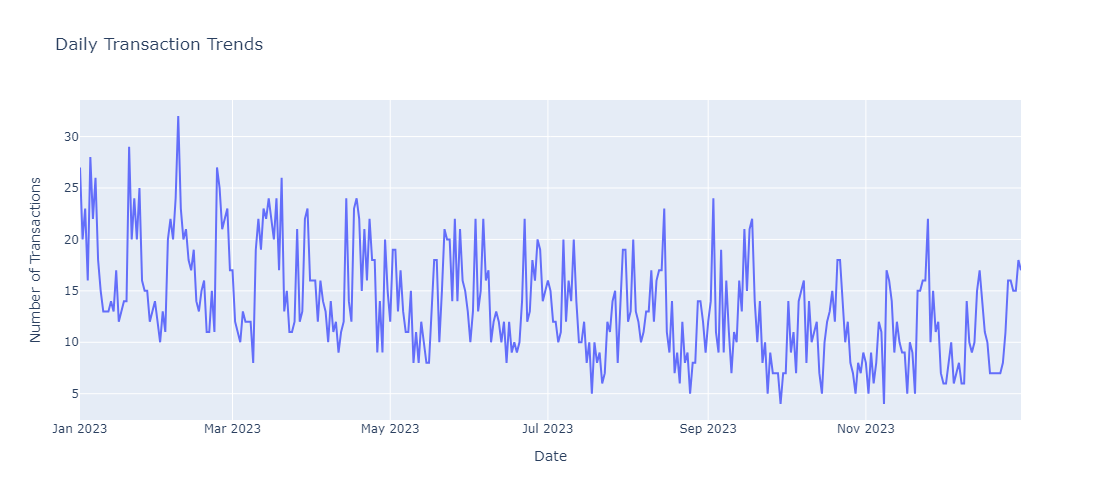

In [70]:
eda_df['Timestamp'] = pd.to_datetime(eda_df['Timestamp'])

daily_trends = eda_df.resample('D', on='Timestamp')['Transaction_ID'].count()
line_plot = go.Scatter(x=daily_trends.index, y=daily_trends.values, mode='lines')

layout = go.Layout(title='Daily Transaction Trends',
                   xaxis=dict(title='Date'),
                   yaxis=dict(title='Number of Transactions'),
                   showlegend=False,
                   height=500,  # Adjust height
                   width=1100)

fig = go.Figure(data=[line_plot], layout=layout)
fig.show()

### I discovered that there's extra space following the `bus` value in the `vehicle_type` column. Therefore, we'll eliminate it.

In [71]:
df['Vehicle_Type'] = df['Vehicle_Type'].str.strip()

### Binary encoding for `vehicle_Type` and `TollBoothID` columns

In [72]:
df['Vehicle_Type'].unique()

array(['Bus', 'Car', 'Motorcycle', 'Truck', 'Van', 'Sedan', 'SUV'],
      dtype=object)

In [73]:
vehicle_types = ['Bus', 'Car', 'Motorcycle', 'Truck', 'Van', 'Sedan', 'SUV']
for vehicle_type in vehicle_types:
    df['is_' + vehicle_type] = (df['Vehicle_Type'] == vehicle_type).astype(int)

# Drop the original Vehicle_Type column
df.drop('Vehicle_Type', axis=1, inplace=True)

In [74]:
df['TollBoothID'].unique()

array(['A-101', 'B-102', 'D-104', 'C-103', 'D-105', 'D-106'], dtype=object)

In [75]:
TollBoothIDs = ['A-101', 'B-102', 'D-104', 'C-103', 'D-105', 'D-106']
for TollBoothID in TollBoothIDs:
    df['is_' + TollBoothID] = (df['TollBoothID'] == TollBoothID).astype(int)

# Drop the original Vehicle_Type column
df.drop('TollBoothID', axis=1, inplace=True)

###  `Geographical_Location` column is to split it into two separate columns representing latitude and longitude.

In [76]:
df['Geographical_Location'].unique()

array(['13.059816123454882, 77.77068662374292',
       '13.042660878688794, 77.47580097259879',
       '12.84197701525119, 77.67547528176169',
       '12.936687032945434, 77.53113977439017',
       '13.21331620748757, 77.55413526894684'], dtype=object)

In [77]:
df[['Latitude', 'Longitude']] = df['Geographical_Location'].str.split(',', expand=True)

# Convert latitude and longitude columns to numeric type
df['Latitude'] = pd.to_numeric(df['Latitude'])
df['Longitude'] = pd.to_numeric(df['Longitude'])

# Drop the original Geographical_Location column
df.drop('Geographical_Location', axis=1, inplace=True)

In [78]:
df['Longitude'].unique()

array([77.77068662, 77.47580097, 77.67547528, 77.53113977, 77.55413527])

In [79]:
df['Latitude'].unique()

array([13.05981612, 13.04266088, 12.84197702, 12.93668703, 13.21331621])

### Convert categorical labels into numerical representations and binary indicator variables

In [80]:
df['Vehicle_Dimensions'] = df['Vehicle_Dimensions'].map({'Large': 3, 'Medium': 2, 'Small': 1})

In [81]:
# Convert categorical labels into numerical representations
df['Fraud'] = df['Fraud_indicator'].map({'Fraud': 1, 'Not Fraud': 0})

# Drop the original Fraud_indicator column
df.drop('Fraud_indicator', axis=1, inplace=True)

In [82]:
# Convert categorical values into binary indicator variables
df['Express_Lane'] = df['Lane_Type'].apply(lambda x: 1 if x == 'Express' else 0)
df['Regular_Lane'] = df['Lane_Type'].apply(lambda x: 1 if x == 'Regular' else 0)

# Drop the original Lane_Type column
df.drop('Lane_Type', axis=1, inplace=True)

### Removing unnecessary columns

In [83]:
df.drop(['FastagID', 'Transaction_ID','State_code','Timestamp'], axis=1, inplace=True)

In [84]:
explore(df)

,data type,percent missing,No. unique,unique values
is_Sedan,int32,0.0,2,"[0, 1]"
is_D-106,int32,0.0,2,"[0, 1]"
is_D-105,int32,0.0,2,"[0, 1]"
Hour,int32,0.0,24,"[11, 14, 18, 2, 6, 10, 15, 20, 1, 7, 12, 17, 2..."
Month,int32,0.0,12,"[1, 2, 3, 4, 5, 6, 8, 9, 10, 7, 11, 12]"
is_Bus,int32,0.0,2,"[1, 0]"
is_Car,int32,0.0,2,"[0, 1]"
is_Motorcycle,int32,0.0,2,"[0, 1]"
is_Truck,int32,0.0,2,"[0, 1]"
is_Van,int32,0.0,2,"[0, 1]"


#### Exporting data for model depolyment script

In [85]:
df.to_csv("after_feature_engineering.csv")

## Model Training, Evaluation, and Feature Importance Analysis Function

In [86]:
def train_evaluate_model(classifier, X_train, X_test, y_train, y_test):
    # Train classifier
    classifier.fit(X_train, y_train)
    
    # Make predictions
    predictions = classifier.predict(X_test)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, predictions)
    
    # Calculate precision, recall, F1 score
    precision = precision_score(y_test, predictions)
    recall = recall_score(y_test, predictions)
    f1 = f1_score(y_test, predictions)
    
    # Calculate training accuracy
    training_accuracy = classifier.score(X_train, y_train)
    
    # Print evaluation metrics
    print(f"Accuracy: {accuracy}")
    print("Confusion Matrix:\n", confusion_matrix(y_test, predictions))
    print("Classification Report:\n", classification_report(y_test, predictions))
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")
    print(f"Training Accuracy: {training_accuracy}")
    
    return classifier

def plot_feature_importance(classifier, X):
    if isinstance(classifier, RandomForestClassifier) or isinstance(classifier, GradientBoostingClassifier):
        feature_importances = pd.Series(classifier.feature_importances_, index=X.columns)
        sorted_feature_importances = feature_importances.sort_values()
        sorted_feature_importances.plot(kind='barh')
        plt.title('Feature Importance')
        plt.xlabel('Relative Importance')
        plt.show()
    elif isinstance(classifier, LogisticRegression):
        feature_importances = pd.Series(classifier.coef_[0], index=X.columns)
        sorted_feature_importances = feature_importances.abs().sort_values()
        sorted_feature_importances.plot(kind='barh')
        plt.title('Feature Importance')
        plt.xlabel('Coefficient Magnitude')
        plt.show()

In [87]:
# Separate features and target variable
X = df.drop(columns=["Fraud"])  # Features
y = df["Fraud"]  # Target variable

In [88]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [89]:
rf_classifier = RandomForestClassifier(random_state=42)
lr_classifier = LogisticRegression(random_state=42)
svm_classifier = SVC(random_state=42)
gb_classifier = GradientBoostingClassifier(random_state=42)

## Random Forest 

Accuracy: 0.988
Confusion Matrix:
 [[783   0]
 [ 12 205]]
Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99       783
           1       1.00      0.94      0.97       217

    accuracy                           0.99      1000
   macro avg       0.99      0.97      0.98      1000
weighted avg       0.99      0.99      0.99      1000

Precision: 1.0
Recall: 0.9447004608294931
F1 Score: 0.9715639810426541
Training Accuracy: 1.0


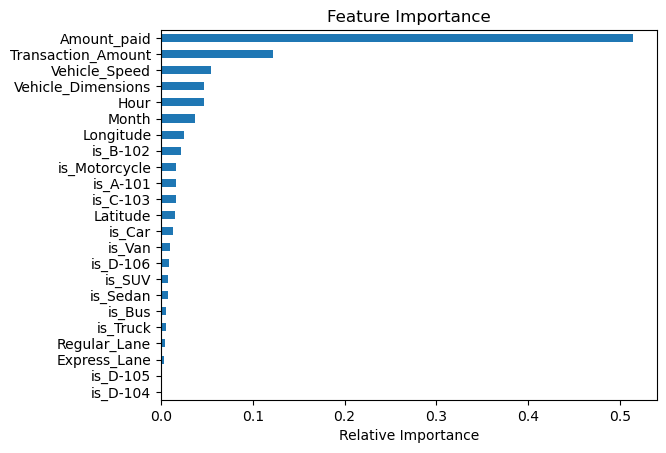

In [90]:
rf_classifier = train_evaluate_model(rf_classifier, X_train, X_test, y_train, y_test)
plot_feature_importance(rf_classifier, X)

## Logisitc Regression

Accuracy: 0.983
Confusion Matrix:
 [[783   0]
 [ 17 200]]
Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99       783
           1       1.00      0.92      0.96       217

    accuracy                           0.98      1000
   macro avg       0.99      0.96      0.97      1000
weighted avg       0.98      0.98      0.98      1000

Precision: 1.0
Recall: 0.9216589861751152
F1 Score: 0.9592326139088729
Training Accuracy: 0.98625


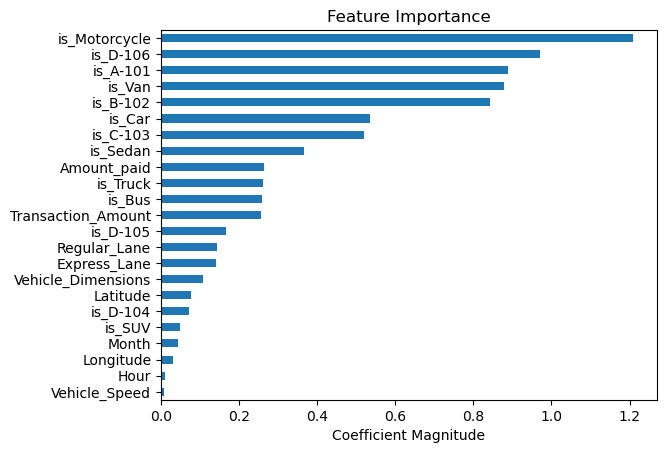

In [91]:
lr_classifier = train_evaluate_model(lr_classifier, X_train, X_test, y_train, y_test)
plot_feature_importance(lr_classifier, X)

## SVM

In [92]:
svm_classifier = train_evaluate_model(svm_classifier, X_train, X_test, y_train, y_test)

Accuracy: 0.983
Confusion Matrix:
 [[783   0]
 [ 17 200]]
Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99       783
           1       1.00      0.92      0.96       217

    accuracy                           0.98      1000
   macro avg       0.99      0.96      0.97      1000
weighted avg       0.98      0.98      0.98      1000

Precision: 1.0
Recall: 0.9216589861751152
F1 Score: 0.9592326139088729
Training Accuracy: 0.985


## Gradient Boosting 

Accuracy: 0.99
Confusion Matrix:
 [[783   0]
 [ 10 207]]
Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99       783
           1       1.00      0.95      0.98       217

    accuracy                           0.99      1000
   macro avg       0.99      0.98      0.99      1000
weighted avg       0.99      0.99      0.99      1000

Precision: 1.0
Recall: 0.9539170506912442
F1 Score: 0.9764150943396226
Training Accuracy: 0.995


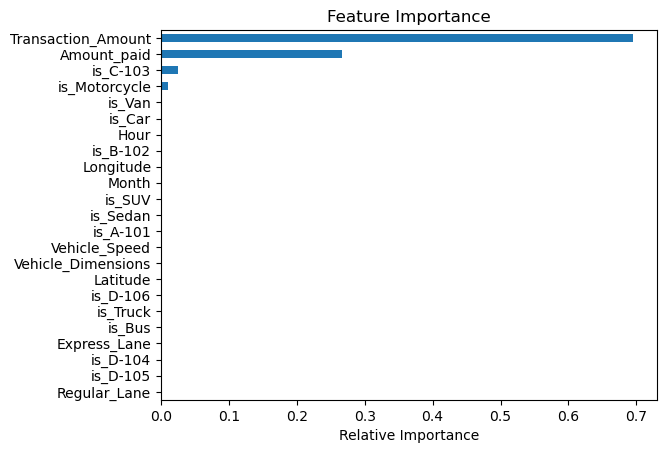

In [93]:
gb_classifier = train_evaluate_model(gb_classifier, X_train, X_test, y_train, y_test)
plot_feature_importance(gb_classifier, X)

In [94]:
scores_df = pd.DataFrame({
    'Model': ['Random Forest', 'Logistic Regression', 'SVM', 'Gradient Boosting'],
    'Accuracy': [accuracy_score(y_test, rf_classifier.predict(X_test)),
                 accuracy_score(y_test, lr_classifier.predict(X_test)),
                 accuracy_score(y_test, svm_classifier.predict(X_test)),
                 accuracy_score(y_test, gb_classifier.predict(X_test))],
    'Precision': [precision_score(y_test, rf_classifier.predict(X_test)),
                  precision_score(y_test, lr_classifier.predict(X_test)),
                  precision_score(y_test, svm_classifier.predict(X_test)),
                  precision_score(y_test, gb_classifier.predict(X_test))],
    'Recall': [recall_score(y_test, rf_classifier.predict(X_test)),
               recall_score(y_test, lr_classifier.predict(X_test)),
               recall_score(y_test, svm_classifier.predict(X_test)),
               recall_score(y_test, gb_classifier.predict(X_test))],
    'F1 Score': [f1_score(y_test, rf_classifier.predict(X_test)),
                 f1_score(y_test, lr_classifier.predict(X_test)),
                 f1_score(y_test, svm_classifier.predict(X_test)),
                 f1_score(y_test, gb_classifier.predict(X_test))]
})

In [95]:
print("Scores Table:")
print(scores_df)

Scores Table:
                 Model  Accuracy  Precision    Recall  F1 Score
0        Random Forest     0.988        1.0  0.944700  0.971564
1  Logistic Regression     0.983        1.0  0.921659  0.959233
2                  SVM     0.983        1.0  0.921659  0.959233
3    Gradient Boosting     0.990        1.0  0.953917  0.976415


### Choosing best classifier

In [96]:
best_model = scores_df.loc[scores_df['F1 Score'].idxmax()]
print("\nBest Model based on F1 Score:")
print(best_model)


Best Model based on F1 Score:
Model        Gradient Boosting
Accuracy                  0.99
Precision                  1.0
Recall                0.953917
F1 Score              0.976415
Name: 3, dtype: object
